In [ ]:
#default_exp sio

In [ ]:
#hide_input
import pivotpy as pp 
pp.nav_links(5)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO●&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  


# Structure IO

> This includes generating POSCAR form [Materials Project](https://materialsproject.org/). You need their API key to run functions in this module where required.

**Note** : To use materials project data frequently, you may need to save their api key into file. Run function below and it saves key to a file and every function will autoload it.

In [ ]:
#export
def save_mp_API(api_key):
    """
    - Save materials project api key for autoload in functions.
    """
    import os
    from pathlib import Path
    home = str(Path.home())
    file = os.path.join(home,'.pivotpyrc')
    lines = []
    if os.path.isfile(file):
        with open(file,'r') as fr:
            lines = fr.readlines()
            lines = [line for line in lines if 'MP_API_KEY' not in line]
        fr.close()
    with open(file,'w') as fw:
        fw.write("MP_API_KEY = {}".format(api_key))
        for line in lines:
            fw.write(line)
        fw.close()

In [ ]:
#export
def load_mp_data(formula,api_key=None,mp_id=None,max_sites = None):
    """
    - Returns fetched data using request api of python form materials project website.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `save_mp_API` function.
        - mp_id    : Optional, you can specify material ID to filter results.
        -max_sites : Option, you can set maximum number of sites to load fastly as it will not fetch all large data sets.
    """
    if api_key is None:
        try:
            import os
            from pathlib import Path
            home = str(Path.home())
            file = os.path.join(home,'.pivotpyrc')
            with open(file,'r') as f:
                lines=f.readlines()
                for line in lines:
                    if 'MP_API_KEY' in line:
                        api_key = line.split('=')[1].strip()
        except:
            return print("api_key not given. provide in argument or generate in file using `save_mp_API(your_mp_api_key)")
    import json
    import requests as req
    url = "https://www.materialsproject.org/rest/v2/materials/_____/vasp?API_KEY=|||||"
    url = url.replace('_____',formula).replace('|||||',api_key)
    resp = req.request(method='GET',url=url)
    jl = json.loads(resp.text)
    all_res = jl['response']
    if max_sites != None:
        sel_res=[]
        for res in all_res:
            if res['nsites'] <= max_sites:
                sel_res.append(res)
        return sel_res
    # Filter to mp_id at last. more preferred
    if mp_id !=None:
        for res in all_res:
            if mp_id == res['material_id']:
                return [res]
    return all_res

In [ ]:
#export
def get_crystal(formula,api_key=None,mp_id=None,max_sites = None):
    """
    - Returns crystal information dictionary including cif data format.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `save_mp_API` function.
        - mp_id    : Optional, you can specify material ID to filter results.
        -max_sites : Option, you can set maximum number of sites to load fastly as it will not fetch all large data sets.
    """
    import json
    import pivotpy as pp
    all_res = load_mp_data(formula=formula,api_key = api_key, mp_id = mp_id, max_sites = max_sites)
    cifs = []
    for res in all_res:
        cif     = res['cif']
        symbol  = res['spacegroup']['symbol']
        crystal = res['spacegroup']['crystal_system']
        unit    = res['unit_cell_formula']
        mp_id   = res['material_id']
        crs = dict(mp_id = mp_id,symbol = symbol, crystal = crystal, unit = unit, cif = cif)
        cifs.append(pp.Dict2Data(crs))
    return cifs

In [ ]:
#export
def get_poscar(formula ,api_key=None,mp_id=None,max_sites = None):
    """
    - Returns poscar information dictionary including cif data format.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `save_mp_API` function.
        - mp_id    : Optional, you can specify material ID to filter results.
        -max_sites : Option, you can set maximum number of sites to load fastly as it will not fetch all large data sets.
    - **Usage**
        - `get_poscar('GaAs',api_key,**kwargs)`. Same result is returned from `Get-POSCAR` command in PowerShell terminal if Vasp2Visual module is installed.
    """
    import numpy as np
    import pivotpy.vr_parser as vp
    crys = get_crystal(formula = formula,api_key = api_key, mp_id = mp_id, max_sites = max_sites)
    poscars = []
    for cr in crys:
        cif = cr.cif
        lines = cif.split('\n')
        if '' in lines.copy():
            lines.remove('')
        abc = []
        abc_ang = []
        index = 0
        for ys in lines:
            if '_cell' in ys:
                if '_length' in ys:
                    abc.append(ys.split()[1])
                if '_angle' in ys:
                    abc_ang.append(ys.split()[1])
                if '_volume' in ys:
                    volume = float(ys.split()[1])
            if '_structural' in ys:
                system = ys.split()[1]
        for i,ys in enumerate(lines):
            if '_atom_site_occupancy' in ys:
                index = i +1 # start collecting pos.
        poses = lines[index:]
        pos_str = ""
        for pos in poses:
            s_p = pos.split()
            pos_str += "{0:>12}  {1:>12}  {2:>12}  {3}\n".format(*s_p[3:6],s_p[0])

        # ======== Cleaning ===========
        abc_ang = [float(ang) for ang in abc_ang]
        abc     = [float(a) for a in abc]
        a = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(1.0,0.0,0.0) # lattic vector a.
        to_rad = 0.017453292519
        gamma = abc_ang[2]*to_rad
        bx,by = abc[1]*np.cos(gamma),abc[1]*np.sin(gamma)
        b = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(bx/abc[0],by/abc[0],0.0) # lattic vector b.
        cz = volume/(abc[0]*by)
        cx = abc[2]*np.cos(abc_ang[1]*to_rad)
        cy = (abc[1]*abc[2]*np.cos(abc_ang[0]*to_rad)-bx*cx)/by
        c = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(cx/abc[0],cy/abc[0],cz/abc[0]) # lattic vector b.
        unit = cr.unit
        elems = [elem for elem in unit.keys()]
        elems = '\t'.join(elems)
        nums  = [str(int(unit[elem])) for elem in unit.keys()]
        nums  = '\t'.join(nums)
        # Get others important info
        symbol  = cr.symbol
        crystal = cr.crystal
        mp_id   = cr.mp_id
        # ======================
        top = system + "\t# [{0}] Generated by PivotPy using Materials Project Database.".format(symbol)
        poscar= "{0}\n  {1}\n {2}\n {3}\n {4}\n  {5}\n  {6}\nDirect\n{7}".format(top,abc[0],a,b,c,elems,nums,pos_str)
        # =======================
        net_out = dict(system = system, symbol = symbol, crystal =crystal,mp_id = mp_id,poscar = poscar)
        poscars.append(vp.Dict2Data(net_out))
    return poscars

In [ ]:
# I alread save key to file, so no need to provide.
pc = get_poscar('GaAs')
pc[1].__dict__.keys()


dict_keys(['system', 'symbol', 'crystal', 'mp_id', 'poscar'])

In [ ]:
print("material_id: ",pc[1].mp_id)
print("spacegroup symbol: ",pc[1].symbol)
print("\n",pc[1].poscar)

material_id:  mp-1244899
spacegroup symbol:  P1

 GaAs	# [P1] Generated by PivotPy using Materials Project Database.
  12.96300988
     1.0000000000000000     0.0000000000000000     0.0000000000000000
     0.0803280581148486     0.9874163554780955     0.0000000000000000
    -0.0513432371290799    -0.0807779476257775     1.1206465800267786
  
  
Direct
  0.95159311    0.59193813    0.22355504  Ga
  0.81973720    0.77788586    0.65820371  Ga
  0.50757822    0.08040183    0.52894399  Ga
  0.23210132    0.92453801    0.94770285  Ga
  0.27318500    0.72025525    0.88851157  Ga
  0.72824496    0.42855610    0.30740558  Ga
  0.89491313    0.30527283    0.53535134  Ga
  0.63840925    0.59137842    0.09531751  Ga
  0.36114656    0.16865329    0.62931073  Ga
  0.74289653    0.41801849    0.73751732  Ga
  0.82954232    0.06459252    0.52349459  Ga
  0.85705192    0.76428481    0.17867374  Ga
  0.66931657    0.17772559    0.62142471  Ga
  0.06608869    0.91874778    0.44273484  Ga
  0.62449060    

In [ ]:
#export
def get_kpath(hsk_list=[],labels=[], n = 5,weight= None ,ibzkpt = None,outfile=None):
    """
    - Generate list of kpoints along high symmetry path. Options are write to file or return KPOINTS list. It generates uniformly spaced point with input `n` as just a scale factor of number of points per unit length. You can also specify custom number of kpoints in an interval by putting number of kpoints as 4th entry in left kpoint.
    - **Parameters**
        - hsk_list : N x 3 list of N high symmetry points, if broken path then [[N x 3],[M x 3],...]. Optionally you can put a 4 values point where 4th entry will decide number of kpoints in current interval. Make sure that points in a connected path patch are at least two i.e. `[[x1,y1,z1],[x2,y2,z2]]` or `[[x1,y1,z1,N],[x2,y2,z2]]`.
        - n        ; int, number per unit length, this makes uniform steps based on distance between points.
        - weight : Float, if None, auto generates weights.
        - gamma  : If True, shifts mesh at gamma point.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - labels : Hight symmetry points labels. Good for keeping record of lables and points indices for later use.                - Note: If you do not want to label a point, label it as 'skip' at its index and it will be removed.
        - outfile: Path/to/file to write kpoints.
    - **Attributes**
        - If `outfile = None`, a tuple is returned which consists of:
            - nkpts   : get_kmesh().nkpts.
            - kpoints : get_kmesh().kpoints.
            - weights : get_kmesh().weights.
    """
    import numpy as np
    if hsk_list:
        try: hsk_list[0][0][0]
        except: hsk_list = [hsk_list] # Make overall 3 dimensions to include breaks in path
    xs,ys,zs, inds,joinat = [],[],[],[0],[] # 0 in inds list is important
    for j,a in enumerate(hsk_list):
        for i in range(len(a)-1):
            _vec = [_a-_b for _a,_b in zip(a[i][:3],a[i+1] )] # restruct point if 4 entries
            _m = np.rint(np.linalg.norm(_vec)*n).astype(int)

            try: _m = a[i][3] # number of points given explicitly.
            except: pass

            inds.append(inds[-1]+_m)
            if j !=0:

                joinat.append(inds[-2]) # Add previous in joinpath
            xs.append(list(np.linspace(a[i][0],a[i+1][0],_m)))
            ys.append(list(np.linspace(a[i][1],a[i+1][1],_m)))
            zs.append(list(np.linspace(a[i][2],a[i+1][2],_m)))
    xs = [y for z in xs for y in z] #flatten values.
    ys = [y for z in ys for y in z]
    zs = [y for z in zs for y in z]
    if weight == None:
        weight = 1/len(xs)
    out_str = ["{0:>16.10f}{1:>16.10f}{2:>16.10f}{3:>12.6f}".format(x,y,z,weight) for x,y,z in zip(xs,ys,zs)]
    out_str = '\n'.join(out_str)
    N = np.size(xs)
    if ibzkpt != None:
        import os
        if os.path.isfile(ibzkpt):
            f = open(ibzkpt,'r')
            lines = f.readlines()
            f.close()
            N = int(lines[1].strip())+N # Update N.
            slines = lines[3:N+4]
            ibz_str = ''.join(slines)
            out_str = "{}\n{}".format(ibz_str,out_str) # Update out_str
    if inds:
        inds[-1] = -1 # last index to -1
    # Remove indices and labels where 'skip' appears
    inds = [i for i,l in zip(inds,labels) if 'skip' not in l]
    labels = [l for l in labels if 'skip' not in l]
    top_str = "Automatically generated using PivotPy with HSK-INDS = {}, LABELS = {}, SEG-INDS = {}\n\t{}\nReciprocal Lattice".format(inds,labels,joinat,N)
    out_str = "{}\n{}".format(top_str,out_str)
    if outfile != None:
        f = open(outfile,'w')
        f.write(out_str)
        f.close()
    else:
        from collections import namedtuple
        mesh = namedtuple('Mesh',['nkpts','kpoints','weights'])
        return mesh(N,np.array([[x,y,x] for x,y,z in zip(xs,ys,zs)]),[weight for x in xs])

In example below, the overall value of `n = 5` is skipped and 4th entry in the point is used instead. In later example, a 'skipk' label removes high symmetry point index.

In [ ]:
get_kpath([[0.5,0.5,0.5,2],[0,0,0]],n=5,ibzkpt='IBZKPT',labels = ['M','Γ']).kpoints

array([[0.5, 0.5, 0.5],
       [0. , 0. , 0. ]])

In [ ]:
get_kpath([[[0.375,0.375,0.5,21],[0,0,0]],[[0.5,0.25,0.5],[0,0,0]],[[0.25,0.25,0.25],[0,0,0]]],n=11,labels = ['M','skip','Γ|M','L'],outfile='kpt.txt')

```shell
Automatically generated using PivotPy with HSK-INDS = [0, 29, -1], LABELS = ['M', 'Γ|M', 'L'], SEG-INDS = [21, 29]
	34
```
`HSK-INDS = [0, 29, -1]` should be `[0,21,29,-1]` but `skip` label removed it. Also after 21, it may have 32 as n=11, but distance smaller than 1 resulted in only 8 points there. This is pretty useful if you don't need to rescale kpoint axis later on based on distance.

## KPOINTS Mesh for Fermi Surface Calculations
- The command `get_kmesh` generates a uniform grid in first Brillouin zone by using ConvexHull, including gamma point by default, however you can select `gamma = False` and even grid to remove gamma point.
- The POSCAR is used to filter points only in first BZ. Use relaxed and same POSCAR you will use in actual calculations. If you use Vasp's auto generated mesh, use ISYM = -1 to list all points and points inside BZ will be filtered later on while plotting Fermi Surface.
- You can visually see mesh by setting `get_kmesh(*args,plot=True,**kwargs)`.
- KPOINTS are written on `outfile` provided, if `plot = False`, then points are output as array and written on file as well.
- IBZKPT file path could be given to argument `ibzkpt` to include it automatically, this is important to include for HSE calculations with `weight = 0`. If `weight = None`, weights are distributed uniformly.
- If you provide `n_xyz = integer`,(recommended for auto uniform mesh) then this is chosen for smallest axes and other axes are scaled according to given POSCAR. 

In [ ]:
#export
def get_kmesh(n_xyz=[5,5,5],weight = None,gamma=True,ibzkpt= None,poscar=None,outfile=None,plot=False):
    """
    - Generate uniform mesh of kpoints. Options are write to file, plot or return KPOINTS list.
    - **Parameters**
        - n_xyz  : List of [nx ny nz] or integer. If integere given, kmesh is autoscaled.
        - weight : Float, if None, auto generates weights.
        - gamma  : Default True, shifts mesh at gamma point.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - poscar : POSCAR file or real space lattice vectors, if None, cubic symmetry is used and it is fast.
        - outfile: Path/to/file to write kpoints.
        - plot   : If True, returns interactive plot. You can look at mesh before you start calculation.
    - **Attributes**
        - If `plot = False`, a tuple is returned which consists of:
            - nkpts   : get_kmesh().nkpts.
            - kpoints : get_kmesh().kpoints.
            - weight : get_kmesh().weight, its one float number, provided or calculated.
    """
    import numpy as np
    from scipy.spatial import ConvexHull
    import math
    if type(n_xyz) == int:
        nx,ny,nz = n_xyz,n_xyz,n_xyz
    else:
        nx,ny,nz = [n for n in n_xyz]
    sx,sy,sz = 0.5,0.5,0.5
    if poscar != None:
        BZ = get_bz(poscar)
        vs = BZ.vertices
        bs = BZ.basis
        vs = np.array([np.linalg.solve(bs.T,v) for v in vs]) # in b1,b2,b3 space space
        sx,sy,sz = [np.max(vs[:,0]),np.max(vs[:,1]),np.max(vs[:,2])]
        nb1,nb2,nb3 = [np.linalg.norm(b) for b in [sx,sy,sz]]
        if np.min([nb1,nb2,nb3]) == nb3 and type(n_xyz) == int:
            nz, nx, ny= n_xyz, np.rint(nb1/nb3*n_xyz).astype(int),np.rint(nb2/nb3*n_xyz).astype(int)
        elif np.min([nb1,nb2,nb3]) == nb2 and type(n_xyz) == int:
            ny, nx, nz= n_xyz, np.rint(nb1/nb2*n_xyz).astype(int),np.rint(nb3/nb2*n_xyz).astype(int)
        elif np.min([nb1,nb2,nb3]) == nb1 and type(n_xyz) == int:
            nx, ny, nz= n_xyz, np.rint(nb2/nb1*n_xyz).astype(int),np.rint(nb3/nb1*n_xyz).astype(int)
    # Make center at gamma if True
    tx,ty,tz = 0,0,0 # Translations in each dirs.
    if gamma == True:
        tx,ty,tz = [np.min(np.abs(np.linspace(-sx,sx,nx))),
                    np.min(np.abs(np.linspace(-sy,sy,ny))),
                    np.min(np.abs(np.linspace(-sz,sz,nz)))]
    points = []
    for i in np.linspace(-sx+tx,sx+tx,nx):
        if nx==1:
            i = i+sx-tx
        for j in np.linspace(-sy+ty,sy+ty,ny):
            if ny==1:
                j = j+sy-ty
            for k in np.linspace(-sz+tz,sz+tz,nz):
                if nz==1:
                    k = k+sz-tz
                # Handle BZ when no POSCAR given and grid shifted for gamma = True
                if i <= sx and j <= sy and k <= sz:
                    points.append([i,j,k])
    points = np.array(points)
    points[np.abs(points) < 1e-10] = 0
    sel_pts = [] # placeholder
    top_info=''
    if poscar != None:
        bz = get_bz(poscar)
        top_info = ' filtered in 1st BZ of rec_basis = [{}, {}, {}]'.format(*bz.basis) # first space is must.
        vs = np.array([np.linalg.solve(bs.T,v) for v in bz.vertices])
        h1 = ConvexHull(vs)
        for p in points:
            h2 = ConvexHull([*vs,p])
            if math.isclose(h2.volume, h1.volume):
                sel_pts.append(p)
        points = np.array(sel_pts)

    if len(points) == 0:
        return print('No KPOINTS in BZ from given input. Try larger input!')
    if weight == None and len(points) != 0:
        weight = float(1/len(points))
    out_str = ["{0:>16.10f}{1:>16.10f}{2:>16.10f}{3:>12.6f}".format(x,y,z,weight) for x,y,z in points]
    out_str = '\n'.join(out_str)
    N = len(points)
    if ibzkpt != None:
        import os
        if os.path.isfile(ibzkpt):
            f = open(ibzkpt,'r')
            lines = f.readlines()
            f.close()
            N = int(lines[1].strip())+N # Update N.
            slines = lines[3:N+4]
            ibz_str = ''.join(slines)
            out_str = "{}\n{}".format(ibz_str,out_str) # Update out_str
    top_str = "Automatically generated uniform mesh using PivotPy with {}x{}x{} grid{}\n\t{}\nReciprocal Lattice".format(nx,ny,nz,top_info,N)
    out_str = "{}\n{}".format(top_str,out_str)
    if outfile != None:
        f = open(outfile,'w')
        f.write(out_str)
        f.close()
    if plot == True:
        import plotly.graph_objects as go
        print('NKPTS: ',N)
        if poscar == None:
            poscar = [[1,0,0],[0,1,0],[0,0,1]]
        BZ = get_bz(poscar)
        bs = BZ.basis
        data= np.array([d[0]*bs[0]+d[1]*bs[1]+d[2]*bs[2] for d in points])
        fig = go.Figure()
        for i,b in enumerate(bs):
            fig.add_trace(go.Scatter3d(x=[0,b[0]], y=[0,b[1]],z=[0,b[2]],mode='lines',name='b<sub>{}</sub>'.format(i+1)))
        fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1],z=data[:,2],mode='markers',name='KPOINTS',marker_size=3))
        for j,pts in enumerate(BZ.faces):
            pts = np.array(pts)
            fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1],z=pts[:,2],mode='lines',surfaceaxis=1,line_color='rgba(130,210,110,0.6)',name = 'F<sub>{}</sub>'.format(j+1) ))
        camera = dict(
            center=dict(x=0.1, y=0.1, z=0.1))
        fig.update_layout(scene_camera=camera,plot_bgcolor='rgb(255,255,255)')
        fig.show()
    else:
        from collections import namedtuple
        mesh = namedtuple('Mesh',['nkpts','kpoints','weight'])
        return mesh(N,points,weight)

The below command generates interactive plotly's plot: 

`get_kmesh(n_xyz=10,poscar=fcc,outfile='kpt.txt',plot=True)`

Interactive plot is shown as Image.

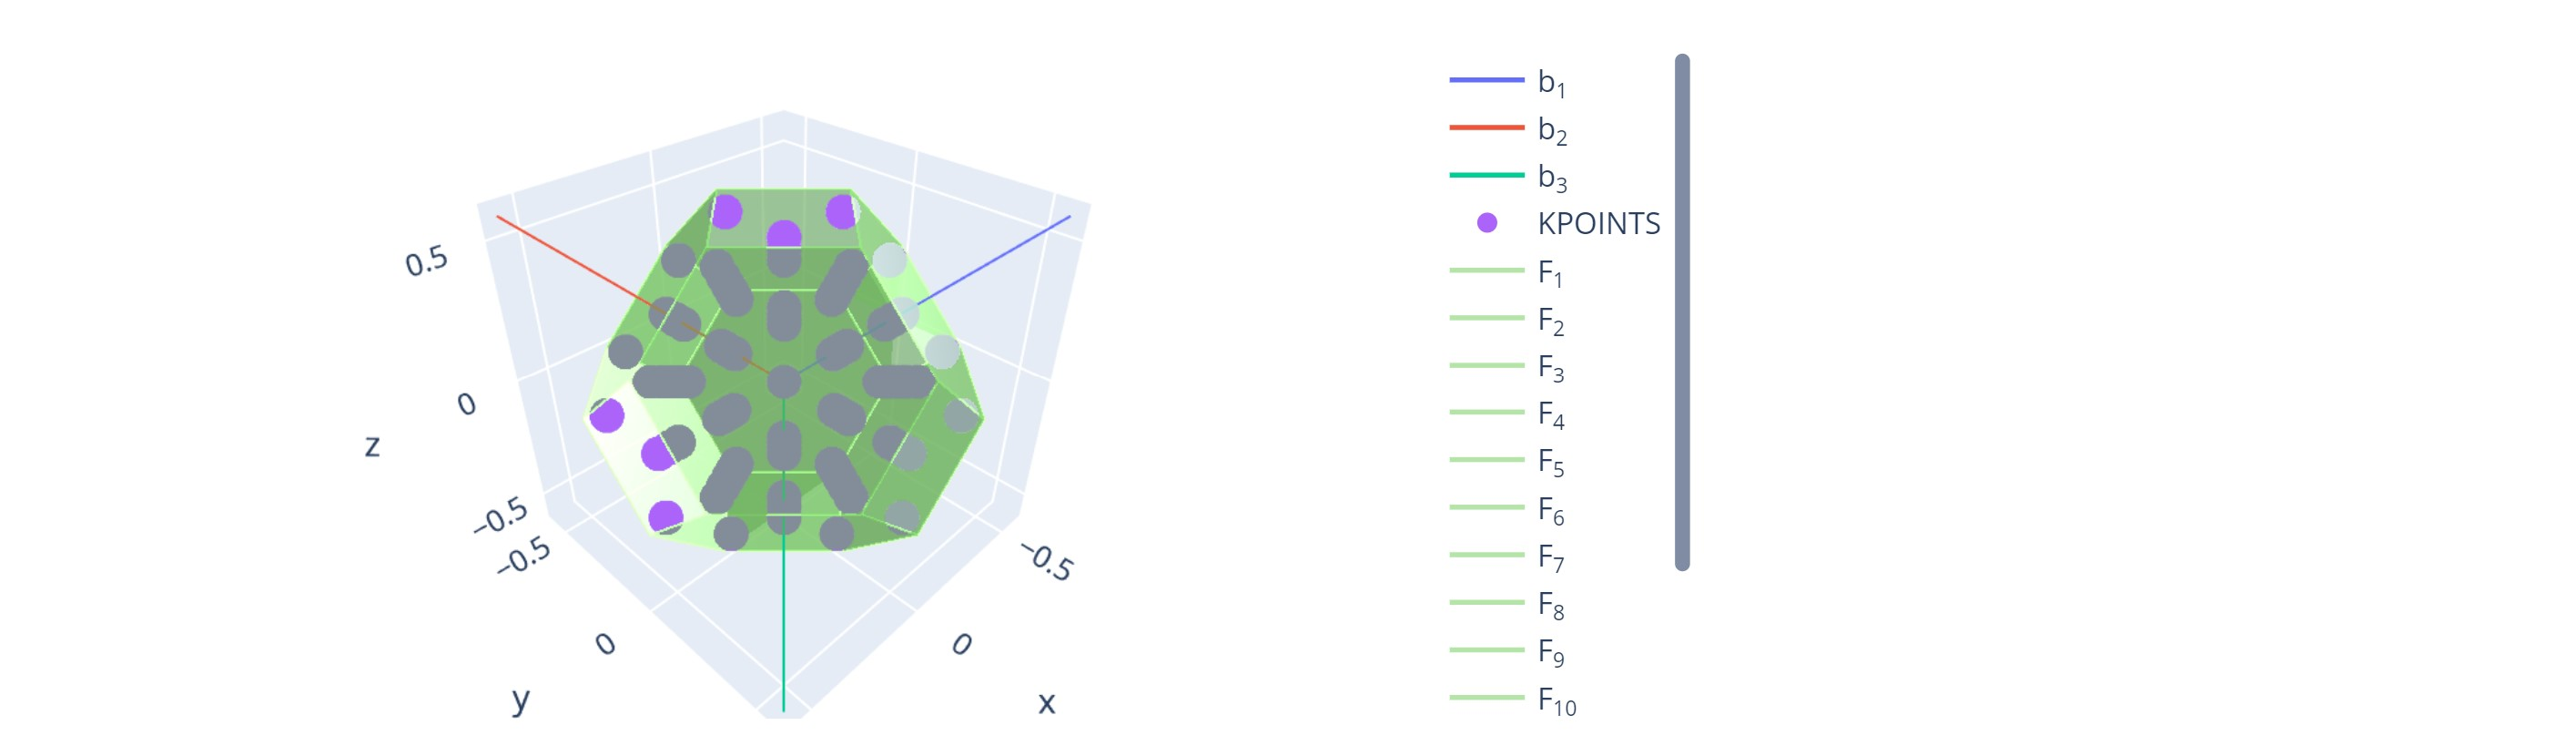

In [ ]:
from IPython.display import Image
Image('./docs/images/get_kmesh.jpg')

In [ ]:
#export
def intersect_3p_p_3v(a,b,c):
    """
    - Returns intersection point of 3 planes in 3D.
    - **Parameters**
        - a,b,c : three vectors in 3D, whose perpendicular planes will be intersected.
    """
    import numpy as np
    M = np.array([a,b,c])
    b = np.array([np.linalg.norm(a)**2,np.linalg.norm(b)**2,np.linalg.norm(c)**2]).reshape(3,1)
    out = []
    if np.linalg.det(M) != 0:
        out = np.linalg.solve(M,b).T
    return out
def centroid(points):
    """
    - Returns centroid of a list of 3D points.
    - **Parameters**
        - points: List[List(len=3)]
    """
    import numpy as np
    _x = [p[0] for p in points]
    _y = [p[1] for p in points]
    _z = [p[2] for p in points]
    _len = len(points)
    _x = sum(_x) / _len
    _y = sum(_y) / _len
    _z = sum(_z) / _len
    center = np.array([_x, _y,_z])
    return center

def order(points):
    """
    - Returns counterclockwise ordered vertices of a plane in 3D. Append first vertex at end to make loop.
    - **Parameters**
        - points: List[List(len=3)]
    """
    import numpy as np
    center = centroid(points)
    ex = [p-c for p,c in zip(points[0],center)]
    ey = np.cross(center,ex)
    ex = ex/np.linalg.norm(ex)  # i
    ey = ey/np.linalg.norm(ey)  # j
    angles= []
    for i in range(0,len(points)):
        v = [p-c for p,c in zip(points[i],center)]
        vx = np.dot(v,ex)
        vy = np.dot(v,ey)
        #print(np.sign(vx),np.sign(vy))
        theta = np.arctan(abs(vy/vx))
        angle = theta # start
        if np.sign(vx) == 1 and np.sign(vy) == 1:
            angle = theta
        if np.sign(vx) == -1 and np.sign(vy) == 1:
            angle = np.pi - theta
        if np.sign(vx) == -1 and np.sign(vy) == -1:
            angle = np.pi + theta
        if np.sign(vx) == 1 and np.sign(vy) == -1:
            angle = 2*np.pi - theta
        if vx == 0 and np.sign(vy) == -1:
            angle = 3*np.pi/2
        if vx == 0 and np.sign(vy) == 1:
            angle = np.pi/2
        if np.sign(vx) == -1 and vy == 0:
            angle = np.pi
        if np.sign(vx) == 1 and vy == 0:
            angle = 2*np.pi
        angles.append([i,angle])
    #print(angles)
    s_angs = np.array(angles)
    ss= s_angs[s_angs[:,1].argsort()]
    #print(ss)
    o_pts =[]
    for s in ss[:,0]:
        pt = np.array(points[int(s)])
        o_pts.append(pt)
    o_pts.append(np.array(o_pts[0]))
    return np.array(o_pts)

def in_vol_sector(test_point,p1,p2,p3):
    """
    - Returns True if test_point lies inside/on the overlapping planes of three vectors.
    - **Parameters**
        - p1,p2,p3: Three vectors points in 3D.
    """
    import numpy as np
    from itertools import permutations
    p_test = np.array(test_point)/np.linalg.norm(test_point)
    p1 = np.array(p1)/np.linalg.norm(p1)
    p2 = np.array(p2)/np.linalg.norm(p2)
    p3 = np.array(p3)/np.linalg.norm(p3)
    if np.dot(p1,np.cross(p2,p3)) == 0:
        return True
    else:
        c = np.array(centroid([p1,p2,p3]))
        _dot_test = np.dot(p_test-c,c)
        if  _dot_test < -1e-5:
            return False
        else:
            return True

def out_bz_plane(test_point,plane):
    """
    - Returns True if test_point is between plane and origin. Could be used to sample BZ mesh in place of ConvexHull.
    - **Parameters**
        - test_points: 3D point.
        - plane      : List of at least three coplanar points.
    """
    import numpy as np
    import math
    outside = True
    p_test = np.array(test_point)
    plane = np.array(plane)
    c = np.array(centroid(plane))
    _dot_ = np.dot(p_test-c,c)
    if _dot_ < -1e-5:
        outside = False
    return outside


def to_xy(v):
    """
    - Rotate a 3D vector v in xy-plane.
    - **Parameters**
        - v: Ponit in 3D.
    """
    import numpy as np
    x = v[0]
    y = 1 # by default to hold if x and y both zero
    if v[1] != 0 and v[2] !=0:
        y = np.sqrt(v[1]**2+v[2]**2)
    d = y
    Rx = [[1,0,0],[0,v[1]/d,v[2]/d],[0,-v[2]/d,v[1]/d]]
    v_out = np.dot(Rx,v)  #v_out = [x,y,0]
    return v_out

def rad_angle(v1,v2):
    """
    - Returns interier angle between two vectors.
    - **Parameters**
        - v1,v2 : Two vectors/points in 3D.
    """
    import numpy as np
    v1 = np.array(v1)
    v2 = np.array(v2)
    norm  = np.linalg.norm(v1)*np.linalg.norm(v2)
    dot_p = np.round(np.dot(v1,v2)/norm,12)
    angle = np.arccos(dot_p)
    return angle

def arctan_full(perp,base):
    """
    - Returns full angle from x-axis counter clockwise.
    - **Parameters**
        - perp: Perpendicular componet of vector including sign.
        - base: Base compoent of vector including sign.
    """
    import numpy as np
    vy = perp
    vx = base
    angle = 0  # Place hodler to handle exceptions
    if vx == 0 and np.sign(vy) == -1:
        angle = 3*np.pi/2
    elif vx == 0 and np.sign(vy) == 1:
        angle = np.pi/2
    else:
        theta = abs(np.arctan(vy/vx))
        if np.sign(vx) == 1 and np.sign(vy) == 1:
            angle = theta
        if np.sign(vx) == -1 and np.sign(vy) == 1:
            angle = np.pi - theta
        if np.sign(vx) == -1 and np.sign(vy) == -1:
            angle = np.pi + theta
        if np.sign(vx) == 1 and np.sign(vy) == -1:
            angle = 2*np.pi - theta
        if np.sign(vx) == -1 and vy == 0:
            angle = np.pi
        if np.sign(vx) == 1 and vy == 0:
            angle = 2*np.pi
    return angle

In [ ]:
import numpy as np
print("Intersection:",intersect_3p_p_3v([np.sqrt(3)/2,0.5,0],[0,0.1,0],[0,0.5,1]))
print("Interier Angle:",rad_angle([0,0.1,0],[0,0.5,1]))
print("Angle with x-axis:",arctan_full(1,0))
print("Rotate to XY",to_xy([np.sqrt(3)/2,0.5,1]))
in_vol_sector([0.1,-0.1,0.1],[1,0,0],[0,0,1],[0,1,0])

Intersection: [[1.09696551 0.1        1.2       ]]
Interier Angle: 1.1071487177940433
Angle with x-axis: 1.5707963267948966
Rotate to XY [0.8660254  1.11803399 0.        ]


False

In [ ]:
#export
def get_bz(poscar = None,loop = True,digits=8):
    """
    - Return required information to construct first Brillouin zone in form of tuple (basis, normals, vertices, faces).
    - **Parameters**
        - poscar : POSCAR file or list of 3 vectors in 3D aslist[list,list,list].
        - loop   : If True, joins the last vertex of a BZ plane to starting vertex in order to complete loop.
        - digits : int, rounding off decimal places, no effect on intermediate calculations, just for pretty final results
    - **Attributes**
        - basis   : get_bz().basis, recprocal lattice basis.
        - normals : get_bz().normals, all vertors that are perpendicular BZ faces/planes.
        - vertices: get_bz().vertices, all vertices of BZ, could be input into ConvexHull for constructing 3D BZ.
        - faces   : get_bz().faces, vertices arranged into faces, could be input to Poly3DCollection of matplotlib for creating BZ from faces' patches.
        - specials : get_bz().specials, Dictionary of high symmetry KPOINTS with keys as points relative to basis and values are corresponding positions in recirprocal coordinates space.
    """
    import os
    import numpy as np
    from scipy.spatial import Voronoi
    from itertools import product
    import math
    if poscar == None and os.path.isfile('./POSCAR') == True:
        poscar = './POSCAR'
    elif poscar == None and os.path.isfile('./POSCAR') == False:
        raise ValueError("Argument 'poscar' expects file 'POSCAR' or 3 basis vectors.")
    lines = []
    a1,a2,a3=[],[],[]
    if np.ndim(poscar) ==2:
        a1,a2,a3 = poscar[0],poscar[1],poscar[2]
    elif os.path.isfile(poscar):
        with open(poscar,'r') as f:
            lines = f.readlines()
            f.close()
        if lines != []:
            a1 = [float(i) for i in lines[2].split()]
            a2 = [float(i) for i in lines[3].split()]
            a3 = [float(i) for i in lines[4].split()]
    else:
        raise FileNotFoundError("'{}' does not exist or not 3 by 3 list.".format(poscar))
    # Process
    V  = np.dot(a1,np.cross(a2,a3))
    b1 = np.cross(a2,a3)/V
    b2 = np.cross(a3,a1)/V
    b3 = np.cross(a1,a2)/V
    s_f= np.sqrt(np.dot(b1,b1))
    b1,b2,b3 = b1/s_f,b2/s_f,b3/s_f # Normalize vectors
    basis = np.array([b1,b2,b3])
    # Get other vectors for BZ
    vectors = []
    for i,j,k in product([0,1,-1],[0,1,-1],[0,1,-1]):
        vectors.append(i*b1+j*b2+k*b3)
    vectors = np.array(vectors)
    # Generate voronoi diagram
    vor = Voronoi(vectors)
    faces = []
    vrd = vor.ridge_dict
    for r in vrd:
        if r[0] == 0 or r[1] == 0:
            verts_in_face = np.array([vor.vertices[i] for i in vrd[r]])
            faces.append(verts_in_face)
    faces = np.array(faces)
    verts = [v for vs in faces for v in vs]
    verts = np.unique(verts,axis=0)

    face_vectors = []
    for f in faces:
        face_vectors.append(2*centroid(f))
    if loop == True:
        faces = [order(face) for face in faces] # order in a loop
    # High symmerty KPOINTS in primitive BZ (positive only)
    mid_faces = np.array([centroid(np.unique(face,axis=0)) for face in faces])
    mid_edges = []
    for f in faces:
        for i in range(len(f)-1):
            # Do not insert point between unique vertices
            if np.isclose(np.linalg.norm(f[i]),np.linalg.norm(f[i+1])):
                mid_edges.append(centroid([f[i],f[i+1]]))
    if mid_edges!=[]:
        mid_edges = np.unique(mid_edges,axis=0) # because faces share edges
        mid_faces = np.concatenate([mid_faces,mid_edges])
    # Bring all high symmetry points together.
    mid_all = np.concatenate([[[0,0,0]],mid_faces,verts])
    mid_basis_all = np.array([np.linalg.solve(basis.T,v) for v in mid_all])

    # Round off results
    mid_all_p    = np.round(mid_all,digits)
    mid_basis_p  = np.round(mid_basis_all,digits)
    bais         = np.round(basis,digits)
    face_vectors = np.round(face_vectors,digits)
    verts        = np.round(verts,digits)
    faces        = [np.round(face,digits) for face in faces]
    one_to_one   = {tuple(x):tuple(y) for x,y in zip(mid_basis_p,mid_all_p)}
    from collections import namedtuple
    BZ = namedtuple('BZ', ['basis', 'normals','vertices','faces','specials'])
    return BZ(basis,face_vectors,verts,np.array(faces),one_to_one)

In [ ]:
import numpy as np
from pivotpy.sio import centroid,order
bbya = 1.2
cbya = 0.8
ofco = [[1,bbya,0],[-1,bbya,0],[0,0,cbya]]
bco = [[1,bbya,cbya],[-1,bbya,cbya],[-1,-bbya,cbya]]
fco = [[1,0,cbya],[1,bbya,0],[0,bbya,cbya]]
bcc = [[1,1,1],[-1,1,1],[-1,-1,1]]
cube = [[1,0,0],[0,1,0],[0,0,1]]
hexa = [[1,0,0],[0.5,np.sqrt(3)/2,0],[0,0,1]]

ctg = [[1,1,cbya],[1,-1,cbya],[-1,-1,cbya]]
tgl = [[0.81915,-0.472937,0.94923],[0,0.94587,0.94923],[-0.81915,-0.472937,0.94923]]
fcc =[[0.0000000000000000,    0.5020149905223673,    0.5020149905223673],
    [0.5020149905223673,    0.0000000000000000,    0.5020149905223673],
     [0.5020149905223673,    0.5020149905223673,    0.0000000000000000]]

basis,normals,vertices,faces,specials = get_bz(fcc,digits=4)
print(basis)
for i,(k,v) in enumerate(specials.items()):
    if i<3:
        print(k,v)

[[-0.57735027  0.57735027  0.57735027]
 [ 0.57735027 -0.57735027  0.57735027]
 [ 0.57735027  0.57735027 -0.57735027]]
(-0.0, 0.0, 0.0) (0.0, 0.0, 0.0)
(0.5, 0.0, 0.5) (0.0, 0.5774, 0.0)
(-0.0, 0.0, 0.5) (0.2887, 0.2887, -0.2887)


C:\Users\mass_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Research\pivotpy\pivotpy\sio.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(abs(vy/vx))
C:\Users\mass_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


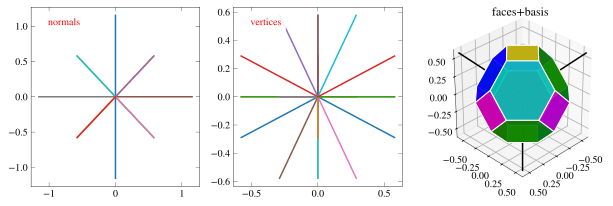

In [ ]:
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pivotpy as pp
axs = pp.init_figure(figsize=(8,2.5),left=0,top=1,bottom=0,right=1,ncols=3)
pos = axs[2].get_position()
axs[2].remove()
for y in normals:
    axs[0].plot([0,y[0]],[0,y[1]])
for y in vertices:
    axs[1].plot([0,y[0]],[0,y[1]])
# 3D
ax3d = plt.gcf().add_axes(pos,projection='3d',azim=45,elev=30)
colors=['m', 'g', 'b', 'y','c', 'm', 'r', 'y','g', 'b', 'g', 'm','y', 'r']
ax3d.add_collection3d(Poly3DCollection(faces,edgecolors=['w'],facecolors=colors[:len(faces)], alpha=0.9))
for y in basis:
    ax3d.plot3D([0,y[0]],[0,y[1]],[0,y[2]],color='k')
#for f in x.faces:
#    ax3d.plot3D(f[:,0],f[:,1],f[:,2],color='r')
#h2=ConvexHull(x.vertices)
#for simplex in h2.simplices:
#    simplex = np.append(simplex, simplex[0])
#    ax.plot3D(vs[simplex, 0], vs[simplex, 1],vs[simplex, 2], 'r',lw=1)
#ax.autoscale_view()
ax3d.set_xlim([-0.6,0.6])
ax3d.set_ylim([-0.6,0.6])
ax3d.set_zlim([-0.6,0.6])
pp.add_text(axs[0],0.1,0.9,'normals')
pp.add_text(axs[1],0.1,0.9,'vertices')
plt.title('faces+basis')
plt.show()

In [ ]:
#export
def plot_bz(poscar_or_bz = None,fill = True,color = 'rgba(168,204,216,0.4)',background = 'rgb(255,255,255)'):
    """
    - Plots interactive figure showing axes,BZ surface, special points and basis, each of which could be hidden or shown.
    - **Parameters**
        - pocar_or_bz: POSCAR or 3 basis vectors' list forming POSCAR. Auto picks in working directory. Output of get_bz() also works.
        - fill       : True by defult, determines whether to fill surface of BZ or not.
        - color      : color to fill surface 'rgba((168,204,216,0.4)` by default.
        - background : Plot background color, default is 'rgb(255,255,255)'.
    - **Returns**
        - fig   : plotly.graph_object's Figure instance.
    """
    import plotly.graph_objects as go
    import numpy as np
    import pivotpy.sio as sio
    if poscar_or_bz == None:
        bz = sio.get_bz(poscar_or_bz)
    else:
        try:
            poscar_or_bz.basis
            bz = poscar_or_bz
        except AttributeError:
            bz = sio.get_bz(poscar_or_bz)

    fig = go.Figure()
    # Axes
    fig.add_trace(go.Scatter3d(x=[0.25,0,0,0,0],y=[0,0,0.25,0,0],z=[0,0,0,0,0.25],
        mode='lines+text',
        text= ["<b>k</b><sub>x</sub>","","<b>k</b><sub>y</sub>","","<b>k</b><sub>z</sub>"],
        line_color='green', legendgroup='Axes',name='Axes'))
    fig.add_trace(go.Cone(x=[0.18,0,0],y=[0,0.18,0],z=[0,0,0.18],
        u=[0.00001,0,0],v=[0,0.00001,0],w=[0,0,    0.00001],showscale=False,
        colorscale='Greens',legendgroup='Axes',name='Axes'))
    # Basis
    for i,b in enumerate(bz.basis):
        fig.add_trace(go.Scatter3d(x=[0,b[0]], y=[0,b[1]],z=[0,b[2]],
            mode='lines+text',legendgroup="b<sub>{}</sub>".format(i+1), line_color='red',
            name="<b>b</b><sub>{}</sub>".format(i+1),text=["","<b>b</b><sub>{}</sub>".format(i+1)]))
        fig.add_trace(go.Cone(x=[0.95*b[0]],y=[0.95*b[1]],z=[0.95*b[2]],
            u=[0.2*b[0]],v=[0.2*b[1]],w=[0.2*b  [2]],showscale=False,colorscale='Reds',
            legendgroup="b<sub>{}</sub>".format(i+1),name="<b>b</b><sub>{}</sub>".format(i+1)))

    # Faces
    face_ind = 0
    fill_axis = None # Placeholder
    legend = True
    for k,pts in enumerate(bz.faces):
        if fill == False:
            color = 'black'
            fill_axis = None
        elif fill == True:
            face_dir = np.abs(sio.centroid(np.unique(pts,axis=0))) # same fill axis in negative axes too
            if np.max(face_dir) == face_dir[0]:
                fill_axis = 0
            elif np.max(face_dir) == face_dir[1]:
                fill_axis = 1
            elif np.max(face_dir) == face_dir[2]:
                fill_axis = 2
        if k != 0:
            legend = False
        fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1],z=pts[:,2],
            mode='lines',line_color=color,    legendgroup='BZ',name='BZ',
            showlegend=legend,surfaceaxis=fill_axis))

    # Special Points
    texts,values =[],[]
    for key,value in bz.specials.items():
        norm = np.round(np.linalg.norm(value),5)
        texts.append("P{}</br>d = {}".format(key,norm))
        values.append([[*value,norm]])

    values = np.array(values).reshape((-1,4))
    norm_max = np.max(values[:,3])
    c_vals = np.array([int(v*255/norm_max) for v in values[:,3]])
    colors = [0 for i in c_vals]
    _unique = np.unique(np.sort(c_vals))[::-1]
    _lnp = np.linspace(0,255,len(_unique)-1)
    _u_colors = ["rgb({},0,{})".format(r,b) for b,r in zip(_lnp,_lnp[::-1])]
    for _un,_uc in zip(_unique[:-1],_u_colors):
        _index = np.where(c_vals == _un)[0]
        for _ind in _index:
            colors[_ind]=_uc

    colors[0]= "rgb(255,215,0)" # Gold color at Gamma!.
    fig.add_trace(go.Scatter3d(x=values[:,0], y=values[:,1],z=values[:,2],
            hovertext=texts,name="HSK",marker_color=colors,mode='markers'))

    camera = dict(center=dict(x=0.1, y=0.1, z=0.1))
    fig.update_layout(scene_camera=camera,paper_bgcolor=background,
        font_family="Times New Roman",font_size= 14,
        scene = dict(aspectmode='data',xaxis = dict(showbackground=False,visible=False),
                        yaxis = dict(showbackground=False,visible=False),
                        zaxis = dict(showbackground=False,visible=False)),
                        margin=dict(r=10, l=10,b=10, t=30))
    return fig

- Below is a BZ plot using command `plot_bz()`. Same color points lie on a sphere, with radius decreasing as red to blue and gamma point in gold color. These color help distinguishing points but the points not always be equivalent, for example in FCC, there are two points on mid of edges connecting square-hexagon and hexagon-hexagon at equal distance from center but not the same points.

In [ ]:
import pivotpy as pp
pp.plotly_to_html(plot_bz([[1,0,0],[0,1,0],[0,0,4]]))

In [ ]:
#hide_input
import pivotpy as pp 
pp.nav_links(5)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO●&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
